In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def rgb2gray(rgb):
  """ A function to convert rgb images to grayscale"""
  return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

170498071/170498071 [==============================] - 2s 0us/step


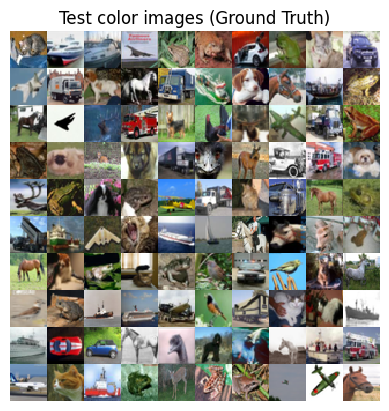

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

imgs_dir = "saved_images"
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis("off")
plt.title("Test color images (Ground Truth)")
plt.imshow(imgs, interpolation = "none")
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

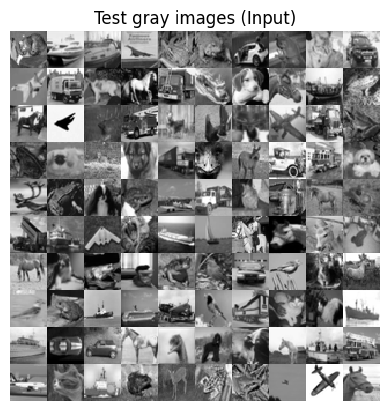

In [4]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [5]:
# output and test color images
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype("float32") / 255

# input grayscale
x_train_gray  = x_train_gray.astype("float32") / 255
x_test_gray = x_test_gray.astype("float32") / 255

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

print(x_train.shape, x_test.shape)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

print(x_train_gray.shape, x_test_gray.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 32, 32, 1) (10000, 32, 32, 1)


In [6]:
input_shape = (img_rows, img_cols, 1)
batch_size = 3

In [7]:
inputs = Input(shape = input_shape, name = "encoder_input")
x = inputs

x = Conv2D(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)
x = Conv2D(filters = 256, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)

shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(256, name = "latent_vector")(x)

encoder = Model(inputs, latent, name = "encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1418496 (5.41 MB)
Trainable params: 1418496 (

In [8]:
latent_inputs = Input(shape=(256,), name = "decoder_input")
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)
x = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)
x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = "same")(x)

outputs = Conv2DTranspose(filters = channels, kernel_size = 3, activation = "sigmoid", padding = "same", name = "decoder_output")(x)

decoder = Model(latent_inputs, outputs, name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 64)        7379

In [9]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = "autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3431811 (13.09 MB)
Trainable params: 3431811 (13.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', verbose=1, save_best_only = True)
autoencoder.compile(loss='mse', optimizer='adam')

callbacks = [lr_reducer, checkpoint]

autoencoder.fit(x_train_gray, x_train, validation_data=(x_test_gray, x_test), epochs=30, batch_size = batch_size, callbacks=callbacks)

Epoch 1/30
16667/16667 [==============================] - ETA: 0s - loss: 0.0154
Epoch 1: val_loss improved from inf to 0.01186, saving model to /content/saved_models/colorized_ae_model.001.h5
16667/16667 [==============================] - 124s 7ms/step - loss: 0.0154 - val_loss: 0.0119 - lr: 0.0010
Epoch 2/30
   11/16667 [..............................] - ETA: 1:24 - loss: 0.0137

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16665/16667 [============================>.] - ETA: 0s - loss: 0.0112
Epoch 2: val_loss improved from 0.01186 to 0.01086, saving model to /content/saved_models/colorized_ae_model.002.h5
16667/16667 [==============================] - 103s 6ms/step - loss: 0.0112 - val_loss: 0.0109 - lr: 0.0010
Epoch 3/30
16662/16667 [============================>.] - ETA: 0s - loss: 0.0103
Epoch 3: val_loss improved from 0.01086 to 0.00994, saving model to /content/saved_models/colorized_ae_model.003.h5
16667/16667 [==============================] - 103s 6ms/step - loss: 0.0103 - val_loss: 0.0099 - lr: 0.0010
Epoch 4/30
16663/16667 [============================>.] - ETA: 0s - loss: 0.0098
Epoch 4: val_loss improved from 0.00994 to 0.00959, saving model to /content/saved_models/colorized_ae_model.004.h5
16667/16667 [==============================] - 105s 6ms/step - loss: 0.0098 - val_loss: 0.0096 - lr: 0.0010
Epoch 5/30
16659/16667 [============================>.] - ETA: 0s - loss: 0.0094
Epoch 5: val_lo

313/313 [==============================] - 2s 4ms/step


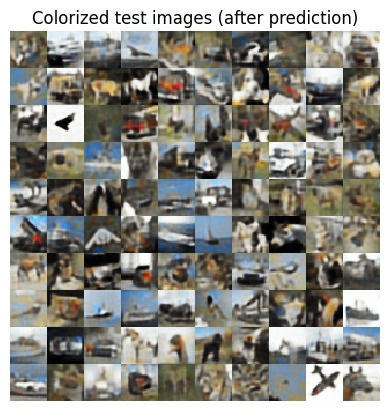

In [11]:
x_decoded = autoencoder.predict(x_test_gray)
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (after prediction)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()